Автор: Лейман М.А.   
Дата создания: 22.03.2025  

# Задание ZALA  
## 1. Обработка датасета






### Классы датасета  
'building': 0,      		здание  
'cable-tower': 1, 		кабельная вышка  
'cultivation-mesh-cage': 2,  	сетка для выращивания  
'landslide': 3, 		оползень  
'pool': 4, 			бассейн  
'prefabricated-house': 5, 	сборный-дом"  
'quarry': 6,			карьер  
'ship': 7, 			корабль  
'vehicle': 8,			транспортное средство  
'well': 9			колодец  



In [1]:
# Названия классов
class_names = ["building", "кабельная-вышка", "cultivation-mesh-cage", "landslide",
               "pool", "prefabricated-house", "quarry", "ship", "vehicle", "well"]


class_names2 = ["здание", "кабельная вышка", "сетка для выращивания", "оползень",
               "бассейн", "сборный-дом", "карьер", "корабль", "транспортное средство", "колодец"]

## Преобразование датасета в формат YOLO

In [ ]:
import os
import xml.etree.ElementTree as ET

# Получаем текущую рабочую папку  
current_directory = os.getcwd()  

print("Текущая папка:", current_directory)  
 

target_original = 'dataset/dataset1/1_datasets_original/target/'    # таргеты XML
xml_dir = os.path.join(current_directory, target_original)  
print("Таргет:", xml_dir)  

image_original = 'dataset/dataset1/1_datasets_original/image/'    # Исходные изображения
image_dir = os.path.join(current_directory, image_original)  
print("Таргет:", image_dir)  

target_yolo_original = 'dataset/dataset1/1_datasets_original/target_yolo/'    # YOLO разметка
output_txt_dir = os.path.join(current_directory, target_yolo_original)  
print(" Таргет YOLO:", output_txt_dir)  



Текущая папка: /home/maksim/develops/python/devsTraining/zala_task
Таргет: /home/maksim/develops/python/devsTraining/zala_task/dataset/dataset1/1_datasets_original/target/
Таргет: /home/maksim/develops/python/devsTraining/zala_task/dataset/dataset1/1_datasets_original/image/
 Таргет YOLO: /home/maksim/develops/python/devsTraining/zala_task/dataset/dataset1/1_datasets_original/target_yolo/


In [ ]:

# Пути к папкам
xml_dir = "/home/maksim/develops/python/devsTraining/zala_task/dataset/dataset1/1_datasets_original/target/"              
output_txt_dir = "/home/maksim/develops/python/devsTraining/zala_task/dataset/dataset1/1_datasets_original/target_yolo"  
image_dir = "/home/maksim/develops/python/devsTraining/zala_task/dataset/dataset1/1_datasets_original/image/"            

In [ ]:
os.makedirs(output_txt_dir, exist_ok=True)

def convert_voc_to_yolo(xml_file, output_dir):
    """ 
        Конвертирует датасет в YOLO формат
    """
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Получаем размеры изображения
    size = root.find("size")
    width = int(size.find("width").text)
    height = int(size.find("height").text)

    yolo_labels = []
    for obj in root.findall("object"):
        class_name = obj.find("name").text
        if class_name not in class_names:
            continue
        class_id = class_names.index(class_name)

        bbox = obj.find("bndbox")
        xmin, ymin, xmax, ymax = map(int, [bbox.find("xmin").text, bbox.find("ymin").text,
                                           bbox.find("xmax").text, bbox.find("ymax").text])

        # Нормализация координат
        x_center = (xmin + xmax) / (2 * width)
        y_center = (ymin + ymax) / (2 * height)
        bbox_width = (xmax - xmin) / width
        bbox_height = (ymax - ymin) / height

        yolo_labels.append(f"{class_id} {x_center} {y_center} {bbox_width} {bbox_height}")

    # Записываем в файл
    filename = os.path.basename(xml_file).replace(".xml", ".txt")
    with open(os.path.join(output_dir, filename), "w") as f:
        f.write("\n".join(yolo_labels))


# Обрабатываем все XML
for xml_file in os.listdir(xml_dir):
    if xml_file.endswith(".xml"):
        convert_voc_to_yolo(os.path.join(xml_dir, xml_file), output_txt_dir)

print("Конвертация завершена!")

Конвертация завершена!


### Разделение датасета  
train  
val  
test  


In [ ]:
import os
import shutil
import random

images_path="dataset/2_datasets_full_yolo/images/train"
labels_path="dataset/2_datasets_full_yolo/labels/train"

def splitting_dataset(image_dir=images_path, label_dir=labels_path ):
    """ 
        Разделяет датасет
    """

    # Пути для разделённых данных
    output_dirs = {
        "train": ("dataset/3_dataset_split/images/train", "dataset/3_dataset_split/labels/train"),
        "val": ("dataset/3_dataset_split/images/val", "dataset/_dataset_split/labels/val"),
        "test": ("dataset/3_dataset_split/images/test", "dataset/3_dataset_split/labels/test"),
    }

    # Создаем папки, если их нет
    for dirs in output_dirs.values():
        os.makedirs(dirs[0], exist_ok=True) 
        os.makedirs(dirs[1], exist_ok=True)  

    # Получаем список файлов
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))])

    # Перемешиваем данные
    random.shuffle(image_files)

    train_split = int(0.7 * len(image_files))
    val_split = int(0.9 * len(image_files))

    splits = {
        "train": image_files[:train_split],
        "val": image_files[train_split:val_split],
        "test": image_files[val_split:],
    }

    # Копируем файлы
    for split, files in splits.items():
        img_out, lbl_out = output_dirs[split]

        for file in files:
            shutil.copy(os.path.join(image_dir, file), os.path.join(img_out, file))

            # Копируем аннотации (YOLO .txt или XML)
            label_file = os.path.splitext(file)[0] + ".txt"
            if os.path.exists(os.path.join(label_dir, label_file)):
                shutil.copy(os.path.join(label_dir, label_file), os.path.join(lbl_out, label_file))

    print("Датасет успешно разделён!")


In [39]:
splitting_dataset(image_dir=images_path, label_dir=labels_path)

Датасет успешно разделён!


### Аугментация

In [ ]:
import os
import cv2
import numpy as np
from glob import glob

# Пути к датасету
input_images_dir = "dataset/3_dataset_split/images/train"
input_labels_dir = "dataset/3_dataset_split/labels/train"
output_images_dir = "dataset/4_datasets_augmented/images/train"
output_labels_dir = "dataset/4_datasets_augmented/labels/train"

# Создаем выходные папки
os.makedirs(output_images_dir, exist_ok=True)
os.makedirs(output_labels_dir, exist_ok=True)


def clip_bbox(bboxes):
    """Ограничивает координаты bbox в диапазоне [0,1]"""
    clipped_bboxes = []
    for box in bboxes:
        class_id, x, y, w, h = box
        x = max(0, min(1, x))
        y = max(0, min(1, y))
        w = max(0, min(1, w))
        h = max(0, min(1, h))
        clipped_bboxes.append([class_id, x, y, w, h])
    return clipped_bboxes


def adjust_brightness(image, factor=1.2):
    """Изменение яркости изображения"""
    return np.clip(image * factor, 0, 255).astype(np.uint8)


def add_noise(image, mean=0, std=25):
    """Добавление случайного гауссовского шума"""
    noise = np.random.normal(mean, std, image.shape).astype(np.int16)  
    noisy_image = np.clip(image.astype(np.int16) + noise, 0, 255)  
    return noisy_image.astype(np.uint8)


def flip_image(image, bboxes, flip_code):
    """Отражение изображения и корректировка аннотаций"""
    h, w = image.shape[:2]
    flipped_img = cv2.flip(image, flip_code)
    
    new_bboxes = []
    for box in bboxes:
        class_id, x, y, bw, bh = box
        if flip_code == 1:  # Горизонтальное отражение
            x = 1 - x
        elif flip_code == 0:  # Вертикальное отражение
            y = 1 - y
        new_bboxes.append([class_id, x, y, bw, bh])
    
    return flipped_img, new_bboxes



def scale_image(image, bboxes, scale_factor):
    """Масштабирование изображения с сохранением YOLO-аннотаций (нормализованных)."""
    h, w = image.shape[:2]
    new_h, new_w = int(h * scale_factor), int(w * scale_factor)

    # Масштабируем изображение
    resized_img = cv2.resize(image, (new_w, new_h))

    if scale_factor > 1:
        # Увеличение -> Обрезка центра
        crop_x = (new_w - w) // 2
        crop_y = (new_h - h) // 2
        final_img = resized_img[crop_y:crop_y + h, crop_x:crop_x + w]

        # Корректируем YOLO боксы (центр + размер)
        new_bboxes = []
        for class_id, x, y, bw, bh in bboxes:
            abs_x = x * new_w  # Денормализация в пиксели
            abs_y = y * new_h
            abs_bw = bw * new_w
            abs_bh = bh * new_h
            
            # Смещаем координаты в новую систему
            new_x = (abs_x - crop_x) / w
            new_y = (abs_y - crop_y) / h
            new_bw = abs_bw / w
            new_bh = abs_bh / h

            # Проверяем, не выходит ли бокс за границы
            if 0 <= new_x <= 1 and 0 <= new_y <= 1:
                new_bboxes.append([class_id, new_x, new_y, new_bw, new_bh])

    else:
        # Уменьшение -> Паддинг (по центру)
        pad_x = (w - new_w) // 2
        pad_y = (h - new_h) // 2
        final_img = np.zeros((h, w, 3), dtype=np.uint8)
        final_img[pad_y:pad_y + new_h, pad_x:pad_x + new_w] = resized_img

        # Корректируем YOLO боксы (центр + размер)
        new_bboxes = []
        for class_id, x, y, bw, bh in bboxes:
            abs_x = x * new_w
            abs_y = y * new_h
            abs_bw = bw * new_w
            abs_bh = bh * new_h

            new_x = (abs_x + pad_x) / w
            new_y = (abs_y + pad_y) / h
            new_bw = abs_bw / w
            new_bh = abs_bh / h

            new_bboxes.append([class_id, new_x, new_y, new_bw, new_bh])

    return final_img, new_bboxes




# Загружаем все изображения
image_paths = glob(os.path.join(input_images_dir, "*.jpg"))

for image_path in image_paths:
    # Загружаем изображение
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Загружаем аннотации (YOLO format)
    label_path = os.path.join(input_labels_dir, os.path.basename(image_path).replace(".jpg", ".txt"))
    
    if not os.path.exists(label_path):
        continue  # Пропускаем, если нет аннотации
    
    with open(label_path, "r") as f:
        lines = f.readlines()
    
    bboxes = []
    for line in lines:
        values = line.split()
        class_id = int(values[0])
        x, y, w, h = map(float, values[1:])
        bboxes.append([class_id, x, y, w, h])
    
    #  Применяем аугментации
    augmented_images = []
    augmented_bboxes = []

    # 0 Горизонтальный флип
    flipped_img, flipped_boxes = flip_image(img, bboxes, flip_code=1)
    augmented_images.append(flipped_img)
    augmented_bboxes.append(flipped_boxes)

    # 1 Вертикальный флип
    flipped_img, flipped_boxes = flip_image(img, bboxes, flip_code=0)
    augmented_images.append(flipped_img)
    augmented_bboxes.append(flipped_boxes)

    # 2 Яркость
    bright_img = adjust_brightness(img, factor=1.4)
    augmented_images.append(bright_img)
    augmented_bboxes.append(bboxes)

    # 3 Яркость
    bright_img = adjust_brightness(img, factor=0.5)
    augmented_images.append(bright_img)
    augmented_bboxes.append(bboxes)

    # 4 Шум
    noisy_img = add_noise(img)
    augmented_images.append(noisy_img)
    augmented_bboxes.append(bboxes)


    # 5 Масштабирование
    scaled_img, scaled_boxes = scale_image(img, bboxes, scale_factor=1.4)
    augmented_images.append(scaled_img)
    augmented_bboxes.append(scaled_boxes)


    # 6  Масштабирование
    scaled_img, scaled_boxes = scale_image(img, bboxes, scale_factor=0.8)
    augmented_images.append(scaled_img)
    augmented_bboxes.append(scaled_boxes)



    # Сохраняем аугментированные изображения и аннотации
    for i, (aug_img, aug_boxes) in enumerate(zip(augmented_images, augmented_bboxes)):
        aug_boxes = clip_bbox(aug_boxes) 
        output_image_path = os.path.join(output_images_dir, f"{os.path.basename(image_path).replace('.jpg', '')}_aug{i}.jpg")
        cv2.imwrite(output_image_path, cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR))
        
        output_label_path = os.path.join(output_labels_dir, f"{os.path.basename(label_path).replace('.txt', '')}_aug{i}.txt")
        with open(output_label_path, "w") as f:
            for bbox in aug_boxes:
                f.write(f"{bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]} {bbox[4]}\n")

print("Аугментированный датасет сохранён!")

Аугментированный датасет сохранён!


### Баланс классов 

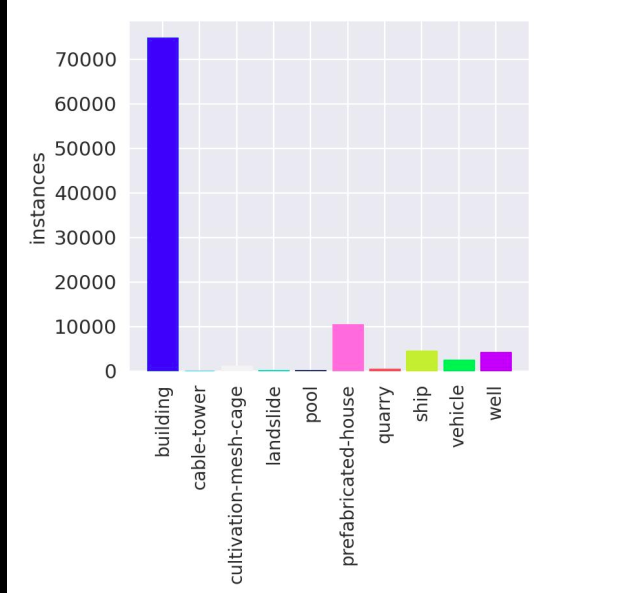  

#### Как видно из графика в датасете  больше всего зданий класс 0, нужно увеличить количество других классов  
увеличим колличество классов аугментируя изображения  где есть классы кроме 0!

### Увеличение датасета

#### выберем данные где есть классы кроме 0 и 5

In [ ]:
import os
import shutil

def filter_and_copy_files(images_dir, annotations_dir, output_images_dir, output_annotations_dir):
    os.makedirs(output_images_dir, exist_ok=True)
    os.makedirs(output_annotations_dir, exist_ok=True)
    
    for annotation_file in os.listdir(annotations_dir):
        annotation_path = os.path.join(annotations_dir, annotation_file)
        
        with open(annotation_path, 'r') as f:
            lines = f.readlines()
            
        # Проверяем, есть ли классы, отличные от 0 и 5
        contains_other_classes = any(line.split()[0] not in {'0', '5'} for line in lines)
        
        if contains_other_classes:
            image_file = annotation_file.replace('.txt', '.jpg')  
            image_path = os.path.join(images_dir, image_file)
            
            if os.path.exists(image_path):
                shutil.copy(annotation_path, os.path.join(output_annotations_dir, annotation_file))
                shutil.copy(image_path, os.path.join(output_images_dir, image_file))
                print(f"Copied: {image_file} and {annotation_file}")

# Укажите пути к папкам
images_dir = 'dataset/5_datasets_copy/images/train'  
annotations_dir = 'dataset/5_datasets_copy/labels/train' 
output_images_dir = 'dataset/6_dataset_filter/filtered_images'  
output_annotations_dir = 'dataset/6_dataset_filter/filtered_annotations'  

# Запускаем фильтрацию
filter_and_copy_files(images_dir, annotations_dir, output_images_dir, output_annotations_dir)


Copied: 694.jpg and 694.txt
Copied: 240.jpg and 240.txt
Copied: 11.jpg and 11.txt
Copied: 188.jpg and 188.txt
Copied: 109.jpg and 109.txt
Copied: 10.jpg and 10.txt
Copied: 650.jpg and 650.txt
Copied: 272.jpg and 272.txt
Copied: 378.jpg and 378.txt
Copied: 554.jpg and 554.txt
Copied: 198.jpg and 198.txt
Copied: 149.jpg and 149.txt
Copied: 390.jpg and 390.txt
Copied: 729.jpg and 729.txt
Copied: 225.jpg and 225.txt
Copied: 89.jpg and 89.txt
Copied: 716.jpg and 716.txt
Copied: 748.jpg and 748.txt
Copied: 458.jpg and 458.txt
Copied: 469.jpg and 469.txt
Copied: 289.jpg and 289.txt
Copied: 659.jpg and 659.txt
Copied: 337.jpg and 337.txt
Copied: 129.jpg and 129.txt
Copied: 669.jpg and 669.txt
Copied: 620.jpg and 620.txt
Copied: 644.jpg and 644.txt
Copied: 823.jpg and 823.txt
Copied: 410.jpg and 410.txt
Copied: 688.jpg and 688.txt
Copied: 580.jpg and 580.txt
Copied: 660.jpg and 660.txt
Copied: 50.jpg and 50.txt
Copied: 600.jpg and 600.txt
Copied: 71.jpg and 71.txt
Copied: 16.jpg and 16.txt
Copi

In [ ]:
import os
import cv2
import numpy as np
from glob import glob

input_images_dir = 'dataset/6_dataset_filter/filtered_images' 
input_labels_dir = 'dataset/6_dataset_filter/filtered_annotations'  

output_images_dir = "dataset/6_datasets_augmented/images/train"
output_labels_dir = "dataset/6_datasets_augmented/labels/train"



def augment_images(input_images_dir, input_labels_dir, output_images_dir, output_labels_dir):

    # Создаем выходные папки
    os.makedirs(output_images_dir, exist_ok=True)
    os.makedirs(output_labels_dir, exist_ok=True)


    def clip_bbox(bboxes):
        """Ограничивает координаты bbox в диапазоне [0,1]"""
        clipped_bboxes = []
        for box in bboxes:
            class_id, x, y, w, h = box
            x = max(0, min(1, x))
            y = max(0, min(1, y))
            w = max(0, min(1, w))
            h = max(0, min(1, h))
            clipped_bboxes.append([class_id, x, y, w, h])
        return clipped_bboxes


    def adjust_brightness(image, bboxes, factor=0.8, scale_factor = 0.8):
        """Изменение яркости изображения"""
        scaled_img, scaled_boxes  = scale_image(image, bboxes, scale_factor=scale_factor)


        return np.clip(scaled_img * factor, 0, 255).astype(np.uint8), scaled_boxes


    def add_noise(image, mean=0, std=35):
        """Добавление случайного гауссовского шума"""
        noise = np.random.normal(mean, std, image.shape).astype(np.int16)  
        noisy_image = np.clip(image.astype(np.int16) + noise, 0, 255) 
        return noisy_image.astype(np.uint8)



    def flip_image(image, bboxes, flip_code):
        """Отражение изображения и корректировка аннотаций"""
        h, w = image.shape[:2]
        flipped_img = cv2.flip(image, flip_code)
        
        new_bboxes = []
        for box in bboxes:
            class_id, x, y, bw, bh = box
            if flip_code == 1:  # Горизонтальное отражение
                x = 1 - x
            elif flip_code == 0:  # Вертикальное отражение
                y = 1 - y
            new_bboxes.append([class_id, x, y, bw, bh])
        
        return flipped_img, new_bboxes


    def scale_image(image, bboxes, scale_factor):
        """Масштабирование изображения с сохранением YOLO-аннотаций (нормализованных)."""
        h, w = image.shape[:2]
        new_h, new_w = int(h * scale_factor), int(w * scale_factor)

        # Масштабируем изображение
        resized_img = cv2.resize(image, (new_w, new_h))

        if scale_factor > 1:
            # Увеличение -> Обрезка центра
            crop_x = (new_w - w) // 2
            crop_y = (new_h - h) // 2
            final_img = resized_img[crop_y:crop_y + h, crop_x:crop_x + w]

            # Корректируем YOLO боксы (центр + размер)
            new_bboxes = []
            for class_id, x, y, bw, bh in bboxes:
                abs_x = x * new_w  # Денормализация в пиксели
                abs_y = y * new_h
                abs_bw = bw * new_w
                abs_bh = bh * new_h
                
                # Смещаем координаты в новую систему
                new_x = (abs_x - crop_x) / w
                new_y = (abs_y - crop_y) / h
                new_bw = abs_bw / w
                new_bh = abs_bh / h

                # Проверяем, не выходит ли бокс за границы
                if 0 <= new_x <= 1 and 0 <= new_y <= 1:
                    new_bboxes.append([class_id, new_x, new_y, new_bw, new_bh])

        else:
            # Уменьшение -> Паддинг (по центру)
            pad_x = (w - new_w) // 2
            pad_y = (h - new_h) // 2
            final_img = np.zeros((h, w, 3), dtype=np.uint8)
            final_img[pad_y:pad_y + new_h, pad_x:pad_x + new_w] = resized_img

            # Корректируем YOLO боксы (центр + размер)
            new_bboxes = []
            for class_id, x, y, bw, bh in bboxes:
                abs_x = x * new_w
                abs_y = y * new_h
                abs_bw = bw * new_w
                abs_bh = bh * new_h

                new_x = (abs_x + pad_x) / w
                new_y = (abs_y + pad_y) / h
                new_bw = abs_bw / w
                new_bh = abs_bh / h

                new_bboxes.append([class_id, new_x, new_y, new_bw, new_bh])

        return final_img, new_bboxes


    # Загружаем все изображения
    image_paths = glob(os.path.join(input_images_dir, "*.jpg"))

    for image_path in image_paths:
        # Загружаем изображение
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Загружаем аннотации (YOLO format)
        label_path = os.path.join(input_labels_dir, os.path.basename(image_path).replace(".jpg", ".txt"))
        
        if not os.path.exists(label_path):
            continue  # Пропускаем, если нет аннотации
        
        with open(label_path, "r") as f:
            lines = f.readlines()
        
        bboxes = []
        for line in lines:
            values = line.split()
            class_id = int(values[0])
            x, y, w, h = map(float, values[1:])
            bboxes.append([class_id, x, y, w, h])
        
        #  Применяем аугментации
        augmented_images = []
        augmented_bboxes = []

        # 0 Горизонтальный флип
        flipped_img, flipped_boxes = flip_image(img, bboxes, flip_code=1)
        augmented_images.append(flipped_img)
        augmented_bboxes.append(flipped_boxes)

        # 1 Вертикальный флип
        flipped_img, flipped_boxes = flip_image(img, bboxes, flip_code=0)
        augmented_images.append(flipped_img)
        augmented_bboxes.append(flipped_boxes)

        # 2  Масштабирование
        scaled_img1, scaled_boxes1 = scale_image(img, bboxes, scale_factor=1.2)
        augmented_images.append(scaled_img1)
        augmented_bboxes.append(scaled_boxes1)


        #  3 Горизонтальный флип c масштабированием
        flipped_img1, flipped_boxes1 = flip_image(scaled_img1, scaled_boxes1, flip_code=1)
        augmented_images.append(flipped_img1)
        augmented_bboxes.append(flipped_boxes1)

        # 4 Вертикальный флип с масштабированием
        flipped_img2, flipped_boxes2 = flip_image(scaled_img1, scaled_boxes1, flip_code=0)
        augmented_images.append(flipped_img2)
        augmented_bboxes.append(flipped_boxes2)


        # 5 Яркость
        bright_img, adjust_bboxes = adjust_brightness(flipped_img1, flipped_boxes1, factor=1.1, scale_factor=0.8)
        augmented_images.append(bright_img)
        augmented_bboxes.append(adjust_bboxes)

        # 6 Яркость
        bright_img, adjust_bboxes = adjust_brightness(flipped_img2, flipped_boxes2, factor=0.9, scale_factor=0.8)
        augmented_images.append(bright_img)
        augmented_bboxes.append(adjust_bboxes)


        # 7 Яркость
        bright_img, adjust_bboxes = adjust_brightness(img, bboxes, factor=0.8, scale_factor=1.2)
        augmented_images.append(bright_img)
        augmented_bboxes.append(adjust_bboxes)

        # 8 Яркость
        bright_img, adjust_bboxes = adjust_brightness(img, bboxes, factor=1.2, scale_factor=1.1)
        augmented_images.append(bright_img)
        augmented_bboxes.append(adjust_bboxes)

        # 9 Шум
        noisy_img = add_noise(bright_img)
        augmented_images.append(noisy_img)
        augmented_bboxes.append(adjust_bboxes)


        # 10 Масштабирование
        scaled_img, scaled_boxes = scale_image(img, bboxes, scale_factor=1.2)
        augmented_images.append(scaled_img)
        augmented_bboxes.append(scaled_boxes)


        # 11  Масштабирование
        scaled_img2, scaled_boxes2 = scale_image(img, bboxes, scale_factor=0.9)
        augmented_images.append(scaled_img2)
        augmented_bboxes.append(scaled_boxes2)



        # Сохраняем аугментированные изображения и аннотации
        for i, (aug_img, aug_boxes) in enumerate(zip(augmented_images, augmented_bboxes)):
            aug_boxes = clip_bbox(aug_boxes) 
            output_image_path = os.path.join(output_images_dir, f"{os.path.basename(image_path).replace('.jpg', '')}_aug1_new{i}.jpg")
            cv2.imwrite(output_image_path, cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR))
            
            output_label_path = os.path.join(output_labels_dir, f"{os.path.basename(label_path).replace('.txt', '')}_aug1_new{i}.txt")
            with open(output_label_path, "w") as f:
                for bbox in aug_boxes:
                    f.write(f"{bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]} {bbox[4]}\n")


    print("Аугментированный датасет сохранён!")



In [23]:
augment_images(input_images_dir, input_labels_dir, output_images_dir, output_labels_dir)

Аугментированный датасет сохранён!


### Баланс классов

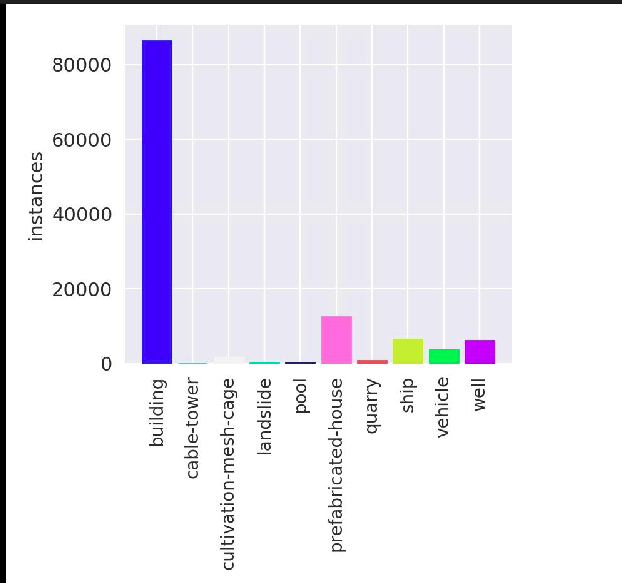 

__Количество классов увеличилось, но увеличилось количество класса 0__   
нужно аугментировать датасет на изображениях где нет классов 0 и 5!

In [ ]:
import os
import shutil

images_path = 'dataset/5_datasets_copy/images/train'  
labels_path = 'dataset/5_datasets_copy/labels/train'  
filtered_images_path = 'dataset/7_dataset_filter/filtered_images'  
filtered_labels_path = 'dataset/7_dataset_filter/filtered_annotations' 

os.makedirs(filtered_labels_path, exist_ok=True)
os.makedirs(filtered_images_path, exist_ok=True)

for label_file in os.listdir(labels_path):
    label_file_path = os.path.join(labels_path, label_file)
    
    with open(label_file_path, "r") as file:
        lines = file.readlines()

    # Проверяем, есть ли в файле классы 0 или 5
    if any(line.startswith(("0 ", "5 ")) for line in lines):
        continue  # Пропускаем этот файл и соответствующее изображение

    # Если файл пустой, пропускаем его
    if not lines:
        continue

    # Если файл не содержит классов 0 и 5, копируем аннотацию
    new_label_file_path = os.path.join(filtered_labels_path, label_file)
    shutil.copy(label_file_path, new_label_file_path)

    # Копируем изображение
    image_file = label_file.replace(".txt", ".jpg") 
    image_src_path = os.path.join(images_path, image_file)
    image_dst_path = os.path.join(filtered_images_path, image_file)

    if os.path.exists(image_src_path):
        shutil.copy(image_src_path, image_dst_path)

print("Фильтрация завершена!")


Фильтрация завершена!


In [18]:

input_images_dir = 'dataset/6_dataset_filter/filtered_images' 
input_labels_dir = 'dataset/6_dataset_filter/filtered_annotations'  

output_images_dir = "dataset/8_datasets_augmented/images/train"
output_labels_dir = "dataset/8_datasets_augmented/labels/train"

augment_images(filtered_images_path, filtered_labels_path, output_images_dir, output_labels_dir)

Аугментированный датасет сохранён!


## датасет DOTA

#### Конвертация аннотаций формата DOTA в YOLO

In [ ]:
import glob

label_paths = glob.glob("dataset/dataset/lables/*.txt")  # путь к аннотациям DOTA
class_names = set()

for label_path in label_paths:
    with open(label_path, "r") as file:
        lines = file.readlines()
    
    for line in lines:
        parts = line.strip().split()
        if len(parts) > 8:  # Проверяем, есть ли название класса (оно 9-й элемент)
            class_name = parts[-2]  # В DOTA имя класса идет перед difficulty
            class_names.add(class_name)

print("Классы датасета:")
print("Найденные классы в DOTA:", class_names)


Классы датасета:
Найденные классы в DOTA: {'container-crane', 'tennis-court', 'baseball-diamond', 'ground-track-field', 'swimming-pool', 'bridge', 'large-vehicle', 'basketball-court', 'storage-tank', 'soccer-ball-field', 'helicopter', 'harbor', 'roundabout', 'small-vehicle', 'plane', 'ship'}


In [17]:
import os
import cv2

# Пути к файлам
dota_labels_path = "dataset/dataset/lables/"  # Папка с DOTA-аннотациями
yolo_labels_path = "dataset/dataset/yolo_labels"  # Папка для YOLO-аннотаций
images_path = "dataset/dataset/images/"  # Папка с изображениями

os.makedirs(yolo_labels_path, exist_ok=True)

# Словарь классов DOTA → YOLO ID
dota_classes = {
    "plane": 0, "ship": 1, "storage-tank": 2, "baseball-diamond": 3, "tennis-court": 4,
    "basketball-court": 5, "ground-track-field": 6, "harbor": 7, "bridge": 8,
    "large-vehicle": 9, "small-vehicle": 10, "helicopter": 11, "roundabout": 12,
    "soccer-ball-field": 13, "swimming-pool": 14, "container-crane": 15
}

# Функция для конвертации аннотации
def convert_dota_to_yolo(dota_file, yolo_file, img_file):
    # Загружаем изображение, чтобы получить его размеры
    image = cv2.imread(img_file)
    if image is None:
        print(f"Ошибка: Не удалось загрузить изображение {img_file}")
        return
    
    img_h, img_w, _ = image.shape  # Получаем (высота, ширина, каналы)

    with open(dota_file, "r") as f:
        lines = f.readlines()

    yolo_annotations = []

    for line in lines:
        parts = line.strip().split()
        if len(parts) < 9:  # Проверяем корректность строки
            continue

        # Читаем координаты 4 точек
        x1, y1, x2, y2, x3, y3, x4, y4 = map(float, parts[:8])
        class_name = parts[8]

        # Пропускаем неизвестные классы
        if class_name not in dota_classes:
            continue

        # YOLO-класс
        class_id = dota_classes[class_name]

        # Находим центр ограничивающего прямоугольника
        x_min = min(x1, x2, x3, x4)
        x_max = max(x1, x2, x3, x4)
        y_min = min(y1, y2, y3, y4)
        y_max = max(y1, y2, y3, y4)

        x_center = (x_min + x_max) / 2.0
        y_center = (y_min + y_max) / 2.0
        box_width = x_max - x_min
        box_height = y_max - y_min

        # Нормализация (делим на ширину и высоту изображения)
        x_center /= img_w
        y_center /= img_h
        box_width /= img_w
        box_height /= img_h

        # Проверка на корректность размеров
        if box_width <= 0 or box_height <= 0:
            continue

        # Формируем строку для YOLO
        yolo_annotations.append(f"{class_id} {x_center:.6f} {y_center:.6f} {box_width:.6f} {box_height:.6f}\n")

    # Записываем YOLO-аннотацию, если есть боксы
    if yolo_annotations:
        with open(yolo_file, "w") as f:
            f.writelines(yolo_annotations)

# Обрабатываем все файлы в папке
for dota_file in os.listdir(dota_labels_path):
    if dota_file.endswith(".txt"):
        # Имя файла без расширения
        file_name = os.path.splitext(dota_file)[0]
        dota_file_path = os.path.join(dota_labels_path, dota_file)
        yolo_file_path = os.path.join(yolo_labels_path, dota_file)
        img_file_path = os.path.join(images_path, file_name + ".png")  # Или .jpg, если изображения в другом формате

        # Проверяем, существует ли изображение
        if not os.path.exists(img_file_path):
            print(f"Пропуск: Нет изображения для {dota_file}")
            continue

        # Конвертация
        convert_dota_to_yolo(dota_file_path, yolo_file_path, img_file_path)

print("Конвертация завершена!")


Конвертация завершена!


### Проверка  и исправление аннотаций

In [1]:
import os
import glob

labels_dir = "/home/maksim/develops/python/devsTraining/zala_task/dataset/dataset/yolo_labels"
image_dir = "/home/maksim/develops/python/devsTraining/zala_task/dataset/dataset/images/"

def normalize_annotations():
    label_files = glob.glob(os.path.join(labels_dir, "*.txt"))

    for label_file in label_files:
        with open(label_file, "r") as f:
            lines = f.readlines()

        new_lines = []
        has_errors = False

        for line in lines:
            parts = line.strip().split()
            if len(parts) < 5:
                continue  # Пропустить строки с ошибками

            class_id, x, y, w, h = map(float, parts[:5])

            # Проверяем координаты
            if x > 1 or y > 1 or w > 1 or h > 1:
                has_errors = True
                x, y, w, h = min(x, 1), min(y, 1), min(w, 1), min(h, 1)

            new_lines.append(f"{int(class_id)} {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n")

        # Если были ошибки — перезаписываем файл
        if has_errors:
            with open(label_file, "w") as f:
                f.writelines(new_lines)
            print(f"Исправлено: {label_file}")

normalize_annotations()
print("Готово! Ошибки в аннотациях исправлены.")


Исправлено: /home/maksim/develops/python/devsTraining/zala_task/dataset/dataset/yolo_labels/P0334.txt
Исправлено: /home/maksim/develops/python/devsTraining/zala_task/dataset/dataset/yolo_labels/P1872.txt
Готово! Ошибки в аннотациях исправлены.


### Количество объектов по классам

In [3]:
import glob

label_paths = glob.glob("/home/maksim/develops/python/devsTraining/zala_task/dataset/dataset/yolo_labels/*.txt")
class_counts = {}

for label_path in label_paths:
    with open(label_path, "r") as file:
        lines = file.readlines()
    
    for line in lines:
        parts = line.split()
        if parts:  # Если строка не пустая
            class_id = int(parts[0])  # Получаем class_id
            class_counts[class_id] = class_counts.get(class_id, 0) + 1  # Считаем

print("Количество объектов по классам:")
# Вывод всех классов и их количества
for class_id, count in sorted(class_counts.items()):
    print(f"Класс {class_id}: {count} объектов")

Количество объектов по классам:
Класс 0: 10622 объектов
Класс 1: 43738 объектов
Класс 2: 8286 объектов
Класс 3: 625 объектов
Класс 4: 3188 объектов
Класс 5: 672 объектов
Класс 6: 476 объектов
Класс 7: 8118 объектов
Класс 8: 2541 объектов
Класс 9: 27357 объектов
Класс 10: 169838 объектов
Класс 11: 713 объектов
Класс 12: 622 объектов
Класс 13: 487 объектов
Класс 14: 2757 объектов
Класс 15: 156 объектов


### Разрежем большие изображения на несколько частей

In [4]:
# Деление  изображений на четыре части
import os
import glob
import cv2
import numpy as np

# Пути к папкам
images_path = "dataset/dataset/images"
labels_path = "dataset/dataset/yolo_labels/"

output_images_path = "dataset/dataset2/dataset_pruning/train_png"
output_labels_path = "dataset/dataset2/dataset_pruning/yolo_labels"

os.makedirs(output_images_path, exist_ok=True)
os.makedirs(output_labels_path, exist_ok=True)

# Получаем список изображений
image_files = glob.glob(os.path.join(images_path, "*.png"))

def split_image(image, label_file, img_name):
    h, w, _ = image.shape
    aspect_ratio = w / h

    if 0.8 <= aspect_ratio <= 1.2:  # Если изображение квадратное → делим на 4
        split_count = 4
        splits = [
            (0, 0, w // 2, h // 2),  # Левый верх
            (w // 2, 0, w, h // 2),  # Правый верх
            (0, h // 2, w // 2, h),  # Левый низ
            (w // 2, h // 2, w, h)   # Правый низ
        ]
    else:  # Если вытянутое → делим на 2 по длинной стороне
        if w > h:  # Горизонтальное изображение → режем по вертикали
            split_count = 2
            splits = [
                (0, 0, w // 2, h),  # Левая половина
                (w // 2, 0, w, h)   # Правая половина
            ]
        else:  # Вертикальное изображение → режем по горизонтали
            split_count = 2
            splits = [
                (0, 0, w, h // 2),  # Верхняя половина
                (0, h // 2, w, h)   # Нижняя половина
            ]

    # Загружаем аннотации
    bboxes = []
    if os.path.exists(label_file):
        with open(label_file, "r") as f:
            for line in f.readlines():
                parts = line.strip().split()
                class_id = int(parts[0])
                x, y, bw, bh = map(float, parts[1:])

                # Преобразуем в абсолютные координаты
                x, y, bw, bh = x * w, y * h, bw * w, bh * h
                x1, y1 = x - bw / 2, y - bh / 2
                x2, y2 = x + bw / 2, y + bh / 2
                bboxes.append((class_id, x1, y1, x2, y2))

    # Разрезаем изображение и аннотации
    for i, (x1, y1, x2, y2) in enumerate(splits):
        new_img = image[y1:y2, x1:x2]
        new_h, new_w, _ = new_img.shape

        new_bboxes = []
        for class_id, bx1, by1, bx2, by2 in bboxes:
            # Проверяем, попадает ли центр бокса в текущий фрагмент
            center_x, center_y = (bx1 + bx2) / 2, (by1 + by2) / 2
            if not (x1 <= center_x < x2 and y1 <= center_y < y2):
                continue  # Пропускаем, если центр вне области

            # Корректируем координаты бокса относительно нового изображения
            bx1, bx2 = max(bx1, x1), min(bx2, x2)
            by1, by2 = max(by1, y1), min(by2, y2)

            # Нормализуем новые координаты
            new_x = ((bx1 + bx2) / 2 - x1) / new_w
            new_y = ((by1 + by2) / 2 - y1) / new_h
            new_bw = (bx2 - bx1) / new_w
            new_bh = (by2 - by1) / new_h

            new_bboxes.append(f"{class_id} {new_x:.6f} {new_y:.6f} {new_bw:.6f} {new_bh:.6f}")

        # Сохраняем изображение
        new_img_name = f"{img_name}_part{i}.png"
        cv2.imwrite(os.path.join(output_images_path, new_img_name), new_img)

        # Сохраняем аннотации
        new_label_file = os.path.join(output_labels_path, new_img_name.replace(".png", ".txt"))
        with open(new_label_file, "w") as f:
            f.write("\n".join(new_bboxes))

# Обрабатываем все изображения
for img_file in image_files:
    img_name = os.path.basename(img_file).replace(".png", "")
    label_file = os.path.join(labels_path, img_name + ".txt")

    image = cv2.imread(img_file)
    split_image(image, label_file, img_name)

print("Нарезка и обработка аннотаций завершена!")

Нарезка и обработка аннотаций завершена!


### конвертируем в jpeg  и сжимаем изображения

In [5]:
import os
import glob
from PIL import Image

input_folder = "dataset/dataset2/dataset_pruning/train_png"
output_folder = "dataset/dataset2/dataset_pruning/train_jpeg"


os.makedirs(output_folder, exist_ok=True)

image_paths = glob.glob(os.path.join(input_folder, "*.png"))

for img_path in image_paths:
    img = Image.open(img_path).convert("RGB")  # Убираем прозрачность

    output_path = os.path.join(output_folder, os.path.basename(img_path).replace(".png", ".jpg"))
    img.save(output_path, "JPEG", quality=85)  # качество 

print("PNG успешно конвертированы в JPEG!")

PNG успешно конвертированы в JPEG!


In [17]:
import os
import shutil
import random

images_path= "dataset/dataset2/dataset_pruning/train_jpeg"
labels_path= "dataset/dataset2/dataset_pruning/yolo_labels"

def splitting_dataset(image_dir=images_path, label_dir=labels_path ):
    """ 
        Разделяет датасет
    """

    # # Пути для разделённых данных
    # output_dirs = {
    #     "train": ("dataset/3_dataset_split/images/train", "dataset/3_dataset_split/labels/train"),
    #     "val": ("dataset/3_dataset_split/images/val", "dataset/3_dataset_split/labels/val"),
    #     "test": ("dataset/3_dataset_split/images/test", "dataset/3_dataset_split/labels/test"),
    # }

    # Пути для разделённых данных
    output_dirs = {
        "train": ("dataset/dataset2/dataset_full1/images/train", "dataset/dataset2/dataset_full1/labels/train"),
        "val": ("dataset/dataset2/dataset_full1/images/val", "dataset/dataset2/dataset_full1/labels/val"),
        "test": ("dataset/dataset2/dataset_full1/images/test", "dataset/dataset2/dataset_full1/labels/test"),
    }



    # Создаем папки, если их нет
    for dirs in output_dirs.values():
        os.makedirs(dirs[0], exist_ok=True) 
        os.makedirs(dirs[1], exist_ok=True)  

    # Получаем список файлов
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))])

    # Перемешиваем данные
    random.shuffle(image_files)

    train_split = int(0.8 * len(image_files))
    val_split = int(0.9 * len(image_files))

    splits = {
        "train": image_files[:train_split],
        "val": image_files[train_split:val_split],
        "test": image_files[val_split:],
    }

    # Копируем файлы
    for split, files in splits.items():
        img_out, lbl_out = output_dirs[split]

        for file in files:
            shutil.copy(os.path.join(image_dir, file), os.path.join(img_out, file))

            # Копируем аннотации (YOLO .txt или XML)
            label_file = os.path.splitext(file)[0] + ".txt"
            if os.path.exists(os.path.join(label_dir, label_file)):
                shutil.copy(os.path.join(label_dir, label_file), os.path.join(lbl_out, label_file))

    print("Датасет успешно разделён!")


In [18]:
splitting_dataset(image_dir=images_path, label_dir=labels_path)

Датасет успешно разделён!


### Деление изображений на части размером 512*512

In [6]:
# Деление изображений на части размером 512*512
import os
import glob
import cv2
import numpy as np

# Пути к папкам
images_path = "dataset/dataset/images"
labels_path = "dataset/dataset/yolo_labels/"

output_images_path = "dataset/dataset2/dataset_pruning_512/train_png"
output_labels_path = "dataset/dataset2/dataset_pruning_512/yolo_labels"

os.makedirs(output_images_path, exist_ok=True)
os.makedirs(output_labels_path, exist_ok=True)

# Получаем список изображений
image_files = glob.glob(os.path.join(images_path, "*.png"))

def split_image(image, label_file, img_name):
    h, w, _ = image.shape

    # Функция для определения числа частей
    def get_split_count(dimension_size):
        if dimension_size > 1023:
            return (dimension_size + 511) // 512  # Деляем на блоки 512px (округление вверх)
        return 1  # Если < 1024, делить не нужно

    # Определяем количество частей по ширине и высоте
    width_splits = get_split_count(w)
    height_splits = get_split_count(h)

    # Определяем размеры шагов разбиения
    step_w = w // width_splits
    step_h = h // height_splits

    # Загружаем аннотации
    bboxes = []
    if os.path.exists(label_file):
        with open(label_file, "r") as f:
            for line in f.readlines():
                parts = line.strip().split()
                class_id = int(parts[0])
                x, y, bw, bh = map(float, parts[1:])

                # Преобразуем в абсолютные координаты
                x, y, bw, bh = x * w, y * h, bw * w, bh * h
                x1, y1 = x - bw / 2, y - bh / 2
                x2, y2 = x + bw / 2, y + bh / 2
                bboxes.append((class_id, x1, y1, x2, y2))

    # Разрезаем изображение и аннотации
    for i in range(height_splits):
        for j in range(width_splits):
            # Границы текущего фрагмента
            y1 = i * step_h
            y2 = min((i + 1) * step_h, h)  # Чтобы не выходить за границы
            x1 = j * step_w
            x2 = min((j + 1) * step_w, w)

            # Обрезаем изображение
            new_img = image[y1:y2, x1:x2]
            new_h, new_w, _ = new_img.shape

            new_bboxes = []
            for class_id, bx1, by1, bx2, by2 in bboxes:
                # Проверяем, попадает ли центр бокса в текущий фрагмент
                center_x, center_y = (bx1 + bx2) / 2, (by1 + by2) / 2
                if not (x1 <= center_x < x2 and y1 <= center_y < y2):
                    continue  # Пропускаем, если центр вне области

                # Корректируем координаты бокса относительно нового изображения
                bx1, bx2 = max(bx1, x1), min(bx2, x2)
                by1, by2 = max(by1, y1), min(by2, y2)

                # Нормализуем новые координаты
                new_x = ((bx1 + bx2) / 2 - x1) / new_w
                new_y = ((by1 + by2) / 2 - y1) / new_h
                new_bw = (bx2 - bx1) / new_w
                new_bh = (by2 - by1) / new_h

                new_bboxes.append(f"{class_id} {new_x:.6f} {new_y:.6f} {new_bw:.6f} {new_bh:.6f}")

            # Сохраняем изображение
            new_img_name = f"{img_name}_part_{i}_{j}.png"
            cv2.imwrite(os.path.join(output_images_path, new_img_name), new_img)

            # Сохраняем аннотации
            new_label_file = os.path.join(output_labels_path, new_img_name.replace(".png", ".txt"))
            with open(new_label_file, "w") as f:
                f.write("\n".join(new_bboxes))

# Обрабатываем все изображения
for img_file in image_files:
    img_name = os.path.basename(img_file).replace(".png", "")
    label_file = os.path.join(labels_path, img_name + ".txt")

    image = cv2.imread(img_file)
    split_image(image, label_file, img_name)

print("Нарезка и обработка аннотаций завершена!")


Нарезка и обработка аннотаций завершена!


### Уменьшение объёма изображений

In [7]:
import os
import glob
from PIL import Image

input_folder = "dataset/dataset2/dataset_pruning_512/train_png"
output_folder = "dataset/dataset2/dataset_pruning_512/train_jpeg"


os.makedirs(output_folder, exist_ok=True)

image_paths = glob.glob(os.path.join(input_folder, "*.png"))

for img_path in image_paths:
    img = Image.open(img_path).convert("RGB")  # Убираем прозрачность

    output_path = os.path.join(output_folder, os.path.basename(img_path).replace(".png", ".jpg"))
    img.save(output_path, "JPEG", quality=100)  # Качество80

print("PNG успешно конвертированы в JPEG!")

PNG успешно конвертированы в JPEG!


### разделение изображений  на train, val,  test

In [ ]:
import os
import shutil
import random

images_path="dataset/dataset2/dataset_pruning_512/train_jpeg"
labels_path="dataset/dataset2/dataset_pruning_512/yolo_labels"

def splitting_dataset(image_dir=images_path, label_dir=labels_path ):
    """ 
        Разделяет датасет
    """

    # # Пути для разделённых данных
    # output_dirs = {
    #     "train": ("dataset/3_dataset_split/images/train", "dataset/3_dataset_split/labels/train"),
    #     "val": ("dataset/3_dataset_split/images/val", "dataset/3_dataset_split/labels/val"),
    #     "test": ("dataset/3_dataset_split/images/test", "dataset/3_dataset_split/labels/test"),
    # }

    # Пути для разделённых данных
    output_dirs = {
        "train": ("dataset/dataset2/dataset_full2/images/train", "dataset/dataset2/dataset_full2/labels/train"),
        "val": ("dataset/dataset2/dataset_full2/images/val", "dataset/dataset2/dataset_full2/labels/val"),
        "test": ("dataset/dataset2/dataset_full2/images/test", "dataset/dataset2/dataset_full2/labels/test"),
    }

    # Создаем папки, если их нет
    for dirs in output_dirs.values():
        os.makedirs(dirs[0], exist_ok=True) 
        os.makedirs(dirs[1], exist_ok=True)  

    # Получаем список файлов
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))])

    # Перемешиваем данные
    random.shuffle(image_files)

    train_split = int(0.8 * len(image_files))
    val_split = int(0.9 * len(image_files))

    splits = {
        "train": image_files[:train_split],
        "val": image_files[train_split:val_split],
        "test": image_files[val_split:],
    }

    # Копируем файлы
    for split, files in splits.items():
        img_out, lbl_out = output_dirs[split]

        for file in files:
            shutil.copy(os.path.join(image_dir, file), os.path.join(img_out, file))

            # Копируем аннотации (YOLO .txt или XML)
            label_file = os.path.splitext(file)[0] + ".txt"
            if os.path.exists(os.path.join(label_dir, label_file)):
                shutil.copy(os.path.join(label_dir, label_file), os.path.join(lbl_out, label_file))

    print("Датасет успешно разделён!")


In [16]:
splitting_dataset(image_dir=images_path, label_dir=labels_path)

Датасет успешно разделён!


###  Проверка изображений на ошибки и исправление

In [3]:
import os
import cv2
from glob import glob

input_dir = "/home/maksim/develops/python/devsTraining/zala_task/dataset/dataset2/dataset_full3/images/train/"
output_dir = "/home/maksim/develops/python/devsTraining/zala_task/dataset/dataset2/dataset_full3/images/train2/"

os.makedirs(output_dir, exist_ok=True)

image_files = glob(os.path.join(input_dir, "*.jpg"))

for img_file in image_files:
    img = cv2.imread(img_file)
    if img is not None:
        output_file = os.path.join(output_dir, os.path.basename(img_file))
        cv2.imwrite(output_file, img, [int(cv2.IMWRITE_JPEG_QUALITY), 95])

print("Пересохранение изображений завершено!")


Corrupt JPEG data: 136 extraneous bytes before marker 0xd9


Пересохранение изображений завершено!


### Изменение размера изображений

In [7]:
import os
import glob
import cv2

images_path = "/home/maksim/develops/python/devsTraining/zala_task/dataset/dataset2/dataset_full3/images/test/"
output_images_path = "/home/maksim/develops/python/devsTraining/zala_task/dataset/dataset2/dataset_full4/images/test/"



os.makedirs(output_images_path, exist_ok=True)

# Получаем список изображений
image_files = glob.glob(os.path.join(images_path, "*.jpg"))

# Функция для изменения размера
def resize_image(image):
    h, w, _ = image.shape

    # Проверяем, если оба измерения больше 512
    if w > 512 and h > 512:
        # Вычисляем коэффициент уменьшения
        scale = 512 / max(w, h)
        new_w = int(w * scale)
        new_h = int(h * scale)
        
        # Изменяем размер
        image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
    
    return image

# Обрабатываем изображения
for img_file in image_files:
    img_name = os.path.basename(img_file)
    
    # Загружаем изображение
    image = cv2.imread(img_file)
    
    # Изменяем размер (если нужно)
    resized_image = resize_image(image)

    # Сохраняем
    cv2.imwrite(os.path.join(output_images_path, img_name), resized_image)

print("Обработка изображений завершена!")


Обработка изображений завершена!
